# Bird Classification

# Introduction
There are so many species of birds and it can get really hard even for experts to tell which family a bird belongs to. Here machine learning can be put to good use.
 
# Objective

In this project, we have 375 bird species and each species has around 150 images. Transfer learning is being used to initialize the weights. `Resnet`, `VGG16`, `InceptionV3` and `Xception` pre-trained models are used. 

In [37]:
# Importing relevant packages...
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from keras import backend as k
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, Input, Conv2D, Dropout, Flatten, Activation, BatchNormalization, Dropout, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tqdm import tqdm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications import Xception
import tensorflow_addons as tfa
import cv2
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import glob
import random

In [2]:
# random seed is a friend for result reproducibility... (Thank you Dr Peter Rubie :) )
# but why 42? Well there is a nice story behind it... let me grab the link for you reaL quick... 
# https://lifetell.com/42-the-meaning-of-life/ , there you go...
np.random.seed(42) 

## Data Preparation

In [4]:
birds = pd.read_csv('E:/datafiles/bird_species/birds.csv') # reading csv that has all the image lables and location...

In [ ]:
birds.head(5)

,class index,filepaths,labels,data set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train


In [8]:
# dividing the dataframe into train, test and validation set...
train = birds[birds['data set'] == 'train']
test = birds[birds['data set'] == 'test']
val = birds[birds['data set'] == 'valid']

In [ ]:
train.shape

(54652, 4)

In [ ]:
test.shape

(1875, 4)

In [ ]:
val.shape

(1875, 4)

In [ ]:
test.head(5)

,class index,filepaths,labels,data set
54652,0,test/ABBOTTS BABBLER/1.jpg,ABBOTTS BABBLER,test
54653,0,test/ABBOTTS BABBLER/2.jpg,ABBOTTS BABBLER,test
54654,0,test/ABBOTTS BABBLER/3.jpg,ABBOTTS BABBLER,test
54655,0,test/ABBOTTS BABBLER/4.jpg,ABBOTTS BABBLER,test
54656,0,test/ABBOTTS BABBLER/5.jpg,ABBOTTS BABBLER,test


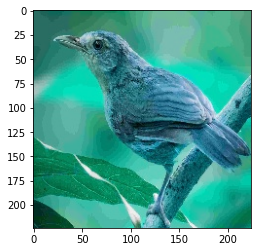

In [5]:
# sample image...
img = cv2.imread(f"E:/datafiles/bird_species/{birds['filepaths'][42]}") # 42 again... 
plt.imshow(img)

In [6]:
# initializing batch size, epochs and input size...
BATCH_SIZE = 32
EPOCHS = 20
INPUT_SIZE = [224, 224]

In [11]:
# image data generator for vgg pretrined model because there are some input preprocessing had been done when vgg was trained on 
# imagenet dataset...

def vgg_dataGenerator():
    vgg_datagen=ImageDataGenerator(rescale=1.0/255.0, 
                               shear_range=0.1, 
                               zoom_range=0.1, 
                               horizontal_flip=True, 
                               vertical_flip = True, 
                                preprocessing_function=preprocess_input)

    vgg_train_generator = vgg_datagen.flow_from_dataframe(
        dataframe = train,
        directory="E:/datafiles/bird_species/",
        x_col="filepaths",
        y_col="labels",
        subset="training",
        batch_size=BATCH_SIZE,
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=INPUT_SIZE,
    )
    return vgg_train_generator
vgg_train_generator = vgg_dataGenerator()

Found 54652 validated image filenames belonging to 375 classes.


In [12]:
# Using imageDataGenerator to read images and creating train, valid, and test generator...

def data_generator():
    datagen=ImageDataGenerator(rescale=1.0/255.0, 
                               shear_range=0.1, 
                               zoom_range=0.1, 
                               horizontal_flip=True, 
                               vertical_flip = True)

    train_generator = datagen.flow_from_dataframe(
        dataframe = train,
        directory="E:/datafiles/bird_species/",
        x_col="filepaths",
        y_col="labels",
        subset="training",
        batch_size=BATCH_SIZE,
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=INPUT_SIZE,
    )

    valid_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

    valid_generator = valid_datagen.flow_from_dataframe(
        dataframe=val,
        directory="E:/datafiles/bird_species/",
        x_col="filepaths",
        y_col="labels",
        batch_size=BATCH_SIZE,
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=INPUT_SIZE,
    )

    test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test,
        directory="E:/datafiles/bird_species/",
        x_col="filepaths",
        y_col="labels",
        batch_size=BATCH_SIZE,
        seed=42,
        shuffle=False,
        class_mode="categorical",
        target_size=INPUT_SIZE,
    )
    return train_generator, valid_generator, test_generator

train_generator, valid_generator, test_generator = data_generator()

Found 54652 validated image filenames belonging to 375 classes.
Found 1875 validated image filenames belonging to 375 classes.
Found 1875 validated image filenames belonging to 375 classes.


In [7]:
# ModelCheckpoint callback is used to save only the best model out of all the epochs...

checkpoint = ModelCheckpoint(filepath="E:/datafiles/bird_species/models/resnet.h5", verbose=2, save_best_only=True)
vgg_checkpoint = ModelCheckpoint(filepath="E:/datafiles/bird_species/models/vgg16.h5", verbose=2, save_best_only=True)
incepV3_checkpoint = ModelCheckpoint(filepath="E:/datafiles/bird_species/models/inception.h5", verbose=2, save_best_only=True)
xcep_checkpoint = ModelCheckpoint(filepath="E:/datafiles/bird_species/models/Xception_v3.h5", verbose=2, save_best_only=True)


# EarlyStopping callback is used to stop the training when accuracy doesn't improve for 5 epochs...
early_stop = EarlyStopping(monitor="val_loss", min_delta=0, patience=3)

# callbacks for early stopping and model checkpoint...
callbacks = [early_stop, checkpoint]
vgg_callbacks = [early_stop, vgg_checkpoint]
incepV3_callbacks = [early_stop, incepV3_checkpoint]
xcep_callbacks = [early_stop, xcep_checkpoint]

In [8]:
# helper function to plot the train and test loss and accuracy...
def plotter(history, model):
    fig, axes = plt.subplots(1, 2, figsize = (10, 5)) # fig of 1 row and 2 cols with 10x5 size...
    # In First column of figure, plotting accuracy and val accuracy from trained model object(history)...
    axes[0].plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy') 
    axes[0].plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
    axes[0].set_xlabel('Epochs', fontsize = 14)
    axes[0].set_ylabel('Accuracy',fontsize = 14)
    axes[0].set_title(f"{model} Accuracy Training vs Testing", fontsize = 14)
    axes[0].legend(loc = 'best') # Location of the legend, whereever is more empty space put legent there (loc= 'best')...
    # In Second column of figure, plotting accuracy and val accuracy from trained model object(history)...
    axes[1].plot(range(1, len(history.history['loss']) + 1), history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
    axes[1].plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
    axes[1].set_xlabel('Epochs', fontsize = 14)
    axes[1].set_ylabel('Loss',fontsize = 14)
    axes[1].set_title(f"{model} Loss Training vs Testing", fontsize = 14)
    axes[1].legend(loc = 'best')
    plt.show()

In [9]:
# input of size 224x224... hight x width = 224 x 224, number of channels = 3...
input = Input(name = 'img_input', shape=INPUT_SIZE+[3])

## Modeling

In [10]:
# network architecture...
def network(base_model, input):
    
    # Removes the values in the graph(network connections) but do not delete the graph itself... helps in RAM cleaning...
    tf.keras.backend.clear_session() 

    # Making Base model layers as non-trainable...
    for i in base_model.layers[:-15]:
        i.trainable=False

    input_layer = base_model(input, training=False)
    
    model = Sequential()
    model.add(base_model)
    model.add(Flatten()) 
    model.add(Activation('relu'))
    model.add(Dense(375)) 
    model.add(Activation('softmax'))
    
    return model

### Resnet

In [ ]:
# Loading weights of the ResNet101 pre-trained model without including top layers... 
#imagenet is a dataset on which ResNet101 was trained...
resnet_model = ResNet101(input_tensor = input, include_top=False, weights="imagenet")

res_model = network(resnet_model, input)

adam = Adam(learning_rate=0.0001) # ADAM optimizer was used to reach the optimal weights...
res_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', tfa.metrics.F1Score(375)])


# Fitting/training model...
res_history = res_model.fit(
    train_generator, 
    steps_per_epoch = len(train) / BATCH_SIZE, # number of steps in each epoch...
    callbacks=callbacks,
    epochs = EPOCHS, 
    validation_data = valid_generator)

Epoch 1/20
1608/1607 [==============================] - ETA: 0s - loss: 5.3944 - accuracy: 0.0470 - f1_score: 0.0397
Epoch 00001: val_loss improved from inf to 5.00828, saving model to ../models\resnet.h5
1607/1607 [==============================] - 446s 275ms/step - loss: 5.3944 - accuracy: 0.0470 - f1_score: 0.0397 - val_loss: 5.0083 - val_accuracy: 0.0816 - val_f1_score: 0.0598
Epoch 2/20
1608/1607 [==============================] - ETA: 0s - loss: 4.6109 - accuracy: 0.1150 - f1_score: 0.1021
Epoch 00002: val_loss improved from 5.00828 to 4.91834, saving model to ../models\resnet.h5
1607/1607 [==============================] - 446s 277ms/step - loss: 4.6109 - accuracy: 0.1150 - f1_score: 0.1021 - val_loss: 4.9183 - val_accuracy: 0.1029 - val_f1_score: 0.0838
Epoch 3/20
1608/1607 [==============================] - ETA: 0s - loss: 4.1806 - accuracy: 0.1684 - f1_score: 0.1563
Epoch 00003: val_loss improved from 4.91834 to 4.26487, saving model to ../models\resnet.h5
1607/1607 [========

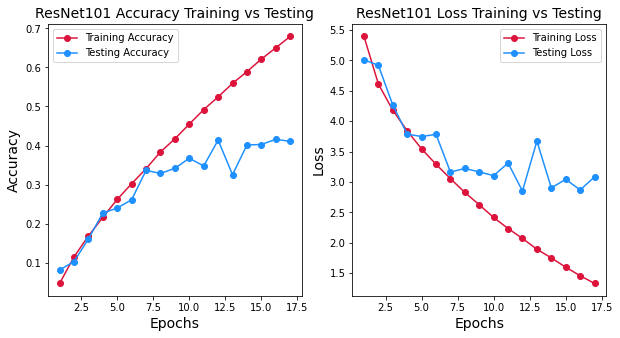

In [ ]:
plotter(res_history, "ResNet101")

In [23]:
res_model = load_model('E:/datafiles/bird_species/models/resnet.h5') # loding model...
res_eval = res_model.evaluate(test_generator) # evaluating model...

59/59 [==============================] - 8s 111ms/step - loss: 2.9539 - accuracy: 0.3920 - f1_score: 0.3749


### VGG16

In [169]:
# Loading weights of the vgg16 pre-trained model without including top layers... 
# imagenet is a dataset on which vgg16 was trained...
vgg16_model = VGG16(input_tensor = input, include_top=False, weights="imagenet")

vgg_model = network(vgg16_model, input)

adam = Adam(learning_rate=0.0001) # ADAM optimizer was used to reach the optimal weights...
vgg_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy',  tfa.metrics.F1Score(375)])


# Fitting/training model...
vgg_history = vgg_model.fit(
    vgg_train_generator, 
    steps_per_epoch = len(train) / BATCH_SIZE, # number of steps in each epoch...
    callbacks=vgg_checkpoint,
    epochs = EPOCHS, 
    validation_data = valid_generator)

Epoch 1/20
1708/1707 [==============================] - ETA: 0s - loss: 5.9280 - accuracy: 0.0038 - f1_score: 1.4834e-04
Epoch 00001: val_loss improved from inf to 5.92695, saving model to ../models\vgg16.h5
1707/1707 [==============================] - 944s 545ms/step - loss: 5.9280 - accuracy: 0.0038 - f1_score: 1.4834e-04 - val_loss: 5.9270 - val_accuracy: 0.0027 - val_f1_score: 1.4184e-05
Epoch 2/20
1708/1707 [==============================] - ETA: 0s - loss: 5.9256 - accuracy: 0.0046 - f1_score: 2.4189e-05
Epoch 00002: val_loss did not improve from 5.92695
1707/1707 [==============================] - 489s 286ms/step - loss: 5.9256 - accuracy: 0.0046 - f1_score: 2.4189e-05 - val_loss: 5.9270 - val_accuracy: 0.0027 - val_f1_score: 1.4184e-05
Epoch 3/20
1708/1707 [==============================] - ETA: 0s - loss: 5.9247 - accuracy: 0.0046 - f1_score: 2.4189e-05
Epoch 00003: val_loss did not improve from 5.92695
1707/1707 [==============================] - 597s 349ms/step - loss: 5.924

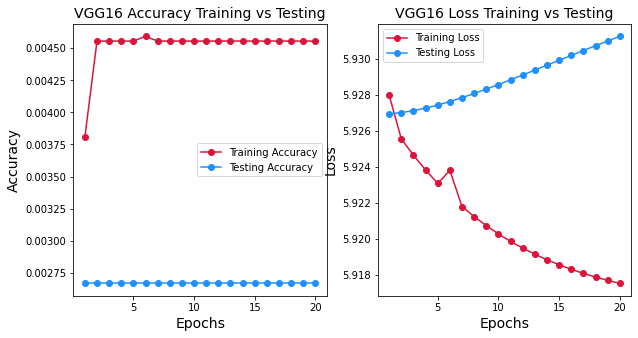

In [171]:
plotter(vgg_history, "VGG16")

In [22]:
vgg_model = load_model('E:/datafiles/bird_species/models/vgg16.h5')
vgg_results = vgg_model.evaluate(test_generator)

59/59 [==============================] - 10s 105ms/step - loss: 5.9270 - accuracy: 0.0027 - f1_score: 1.4184e-05


### Inception

In [12]:
# Loading weights of the InceptionV3 pre-trained model without including top layers... 
# imagenet is a dataset on which InceptionV3 was trained...
inception_model = InceptionV3(input_tensor = input, include_top=False, weights="imagenet")

incepV3_model = network(inception_model, input)

adam = Adam(learning_rate=0.001) # ADAM optimizer was used to reach the optimal weights...
incepV3_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', tfa.metrics.F1Score(375)])


# Fitting/training model...
incepV3_history = incepV3_model.fit(
    train_generator, 
    steps_per_epoch = len(train) / BATCH_SIZE, # number of steps in each epoch...
    callbacks=incepV3_checkpoint,
    epochs = EPOCHS, 
    validation_data = valid_generator)

Epoch 1/20
1708/1707 [==============================] - ETA: 0s - loss: 12.6473 - accuracy: 0.4532 - f1_score: 0.4506
Epoch 00001: val_loss improved from inf to 4.51847, saving model to ../models\inception.h5
1707/1707 [==============================] - 500s 291ms/step - loss: 12.6473 - accuracy: 0.4532 - f1_score: 0.4506 - val_loss: 4.5185 - val_accuracy: 0.7296 - val_f1_score: 0.7152
Epoch 2/20
1708/1707 [==============================] - ETA: 0s - loss: 7.2494 - accuracy: 0.6763 - f1_score: 0.6742
Epoch 00002: val_loss improved from 4.51847 to 3.48403, saving model to ../models\inception.h5
1707/1707 [==============================] - 383s 224ms/step - loss: 7.2494 - accuracy: 0.6763 - f1_score: 0.6742 - val_loss: 3.4840 - val_accuracy: 0.8016 - val_f1_score: 0.7923
Epoch 3/20
1708/1707 [==============================] - ETA: 0s - loss: 5.7817 - accuracy: 0.7428 - f1_score: 0.7413
Epoch 00003: val_loss improved from 3.48403 to 3.10805, saving model to ../models\inception.h5
1707/170

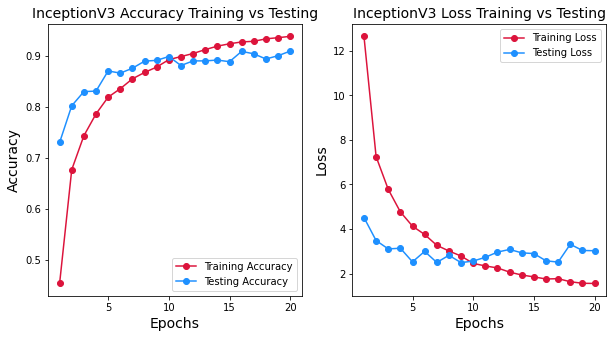

In [13]:
plotter(incepV3_history, "InceptionV3")

In [20]:
incepV3_results = incepV3_model.evaluate(test_generator)

59/59 [==============================] - 3s 42ms/step - loss: 2.3661 - accuracy: 0.9163 - f1_score: 0.9136


### Xception

In [15]:
base_model = Xception(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
Xception_model = network(base_model, input)

In [16]:
adam = Adam(learning_rate=0.0001) # ADAM optimizer was used to reach the optimal weights...
Xception_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', tfa.metrics.F1Score(375)])
# Fitting/training model...
Xception_history = Xception_model.fit(
    train_generator, 
    steps_per_epoch = len(train) / BATCH_SIZE, # number of steps in each epoch...
    callbacks=xcep_callbacks,
    epochs = EPOCHS, 
    validation_data = valid_generator)

Epoch 1/20
1708/1707 [==============================] - ETA: 0s - loss: 1.5255 - accuracy: 0.6603 - f1_score: 0.6639
Epoch 00001: val_loss improved from inf to 0.30388, saving model to ../models\Xception_v3.h5


c:\datascience\python\machine_learning\venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1707/1707 [==============================] - 358s 208ms/step - loss: 1.5255 - accuracy: 0.6603 - f1_score: 0.6639 - val_loss: 0.3039 - val_accuracy: 0.9088 - val_f1_score: 0.9062
Epoch 2/20
1708/1707 [==============================] - ETA: 0s - loss: 0.4567 - accuracy: 0.8766 - f1_score: 0.8756
Epoch 00002: val_loss improved from 0.30388 to 0.19693, saving model to ../models\Xception_v3.h5
1707/1707 [==============================] - 368s 215ms/step - loss: 0.4567 - accuracy: 0.8766 - f1_score: 0.8756 - val_loss: 0.1969 - val_accuracy: 0.9445 - val_f1_score: 0.9432
Epoch 3/20
1708/1707 [==============================] - ETA: 0s - loss: 0.2946 - accuracy: 0.9180 - f1_score: 0.9173
Epoch 00003: val_loss improved from 0.19693 to 0.18524, saving model to ../models\Xception_v3.h5
1707/1707 [==============================] - 375s 219ms/step - loss: 0.2946 - accuracy: 0.9180 - f1_score: 0.9173 - val_loss: 0.1852 - val_accuracy: 0.9429 - val_f1_score: 0.9415
Epoch 4/20
1708/1707 [=============

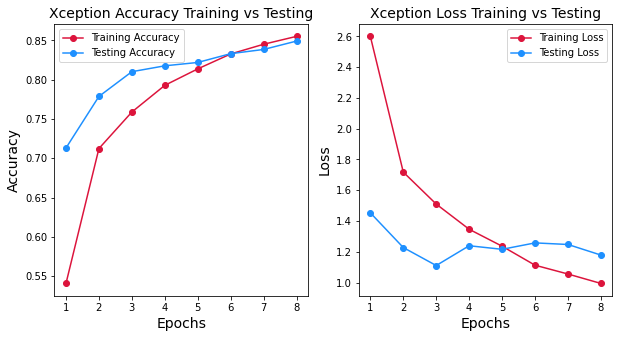

In [ ]:
plotter(Xception_history, "Xception")

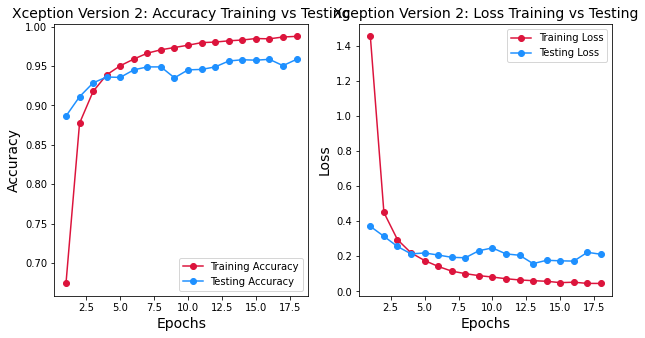

In [ ]:
plotter(Xception_history, "Xception Version 2:")

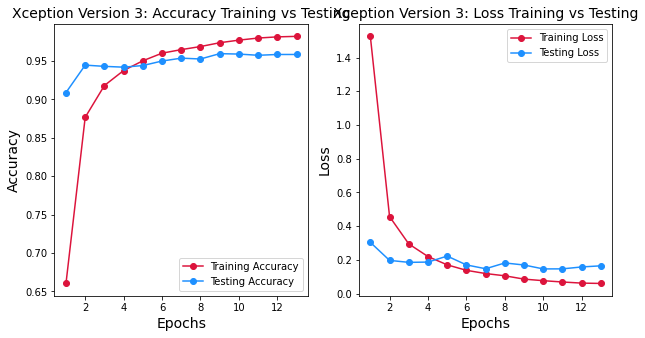

In [17]:
plotter(Xception_history, "Xception Version 3:")

In [20]:
Xception_model = load_model('E:/datafiles/bird_species/models/Xception.h5')
Xception_model_results = Xception_model.evaluate(test_generator)

59/59 [==============================] - 5s 82ms/step - loss: 0.8254 - accuracy: 0.8288 - f1_score: 0.8242


In [22]:
Xception_model_v2 = load_model('E:/datafiles/bird_species/models/Xception_v2.h5')
Xception_model_v2_results = Xception_model_v2.evaluate(test_generator)

59/59 [==============================] - 6s 82ms/step - loss: 0.1162 - accuracy: 0.9637 - f1_score: 0.9631


In [23]:
Xception_model_v3 = load_model('E:/datafiles/bird_species/models/Xception_v3.h5')
Xception_model_v3_results = Xception_model_v3.evaluate(test_generator)

59/59 [==============================] - 5s 82ms/step - loss: 0.1024 - accuracy: 0.9696 - f1_score: 0.9683


## Model Evaluation

In [34]:
y_pred = Xception_model_v3.predict(test_generator)
y_pred = np.argmax(y_pred,axis=1)

In [35]:
confusion_mat = confusion_matrix(test_generator.classes, y_pred)

In [38]:
# finding the test accuracy
accuracy = accuracy_score(test_generator.classes,y_pred)
# calculating the f1 score
f1_score_val = f1_score(test_generator.classes, y_pred, average='weighted')
# calculating the precision
precision_score_val = precision_score(test_generator.classes,y_pred,average='weighted')
# calculating the recall_score
recall_score_val = recall_score(test_generator.classes,y_pred,average='weighted')

Model Results:
 
      Accuracy: 0.97
 
      F1 Score:0.968
 
      Precision Score: 0.976
 
      Recall Score: 0.97



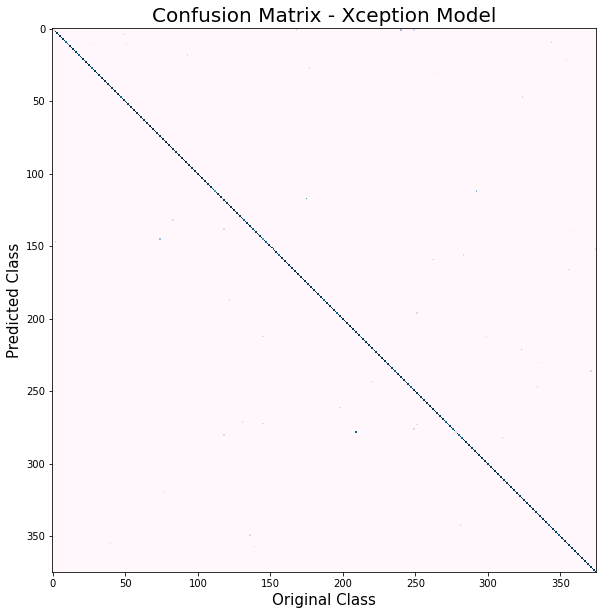

In [39]:
print(f'''Model Results:\n 
      Accuracy: {round(accuracy,3)}\n 
      F1 Score:{round(f1_score_val,3)}\n 
      Precision Score: {round(precision_score_val,3)}\n 
      Recall Score: {round(recall_score_val,3)}\n''')

plt.figure(figsize=(10,10))
plt.imshow(confusion_mat, cmap='PuBu', interpolation='nearest')
plt.title("Confusion Matrix - Xception Model", fontsize = 20)
plt.xlabel("Original Class", fontsize = 15)
plt.ylabel("Predicted Class", fontsize = 15)
plt.show()

In [61]:
# function to perform minor image processing and make prediction...
# img_path: path of image needs to be classified...
# model: model that needs to be used to make prediction...
def classify_birds(img_path, model): 
    img = cv2.imread(img_path) # Reading img...
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resizing the img to 224x224...
    img = cv2.resize(img, (224, 224)) 
    
    # converting img data to array...
    img_array = image.img_to_array(img) 
    
    # reshaping to have 3 channels and making prediction...
    img_array = np.array(img_array).reshape(-1,224,224,3) 
    prediction = model.predict((1.0/255.0)*img_array)
    
    # returning the probability values of each class(prediction) and processed image(img)...
    return prediction, img 
    

In [62]:
# function to pass each img path at a time to classify_driver() function... 
# model: model that needs to be used to make prediction...
def make_pred(model):
    predictions = [] # list to store all the predictions...
    test_imgs = [] # list to store all the images that are being tested...
    
    # iterating over each image...
    for filepath in tqdm(glob.iglob('E:/datafiles/bird_species/images_to_test/*.jpg')): 
        
        # calling classify_driver() with img file path and model that needs to be used...
        row, img = classify_birds(filepath, model)
        
        # storing img that was tested...
        test_imgs.append(img)
        
        # splitting the filepath on '\' and selecting the last element i.e., img name...
        file_name = filepath.split("\\")[-1] 
        
        # storing all the predictions row wise...
        row = list(row[0])
        row.insert(0, file_name)
        predictions.append(row)
    
    # returning the probability value of each class for all the images (predictions) and the img...
    return predictions, test_imgs 

In [63]:
# Function to display images and their class names...
# predictions: the probability value of each class for all the images...
def image_grid(predictions, dict): 
    fig, ax = plt.subplots(5,2, figsize = (100,100)) # grid of 4x5 and plot size 100x100...
    count1 = count2 = 0 # count1: row iterator, count2: column iterator...
    for i in range(10): # testing 20 images...
        
        # if i is divisible by number of columns(5), increase the rows index and make the column iterator 0...
        # traversing left to right then top to bottom... (0,0 > 0,1 > 0,2 > ... > 3,2 > 3,3 > 3,4)
        if i%2 == 0 and i != 0:
            count1 += 1
            count2 = 0
            
        # displaying the image in a particular block of the grid...
        ax[count1, count2].imshow(test_imgs[i])
        
        # fnding class name from probabilities... maximum probability is the class of the image...
#         predicted_class = np.where(predictions[i][1:] == np.amax(predictions[i][1:]))[0][0]
        predicted_class = np.argmax(predictions[i][1:])
#         print(predicted_class)
        # setting the predicted class as the title...
        ax[count1, count2].set_title(dict[predicted_class], size=80)

        # hiding the x and y ticks...
        ax[count1, count2].axis("off")
        
        # increasing the column iterator...
        count2 += 1
    plt.show() # displaying the whole grid...

In [64]:
predictions, test_imgs = make_pred(Xception_model_v3)

10it [00:00, 13.92it/s]


In [41]:
dict = {value:key for key, value in test_generator.class_indices.items()}

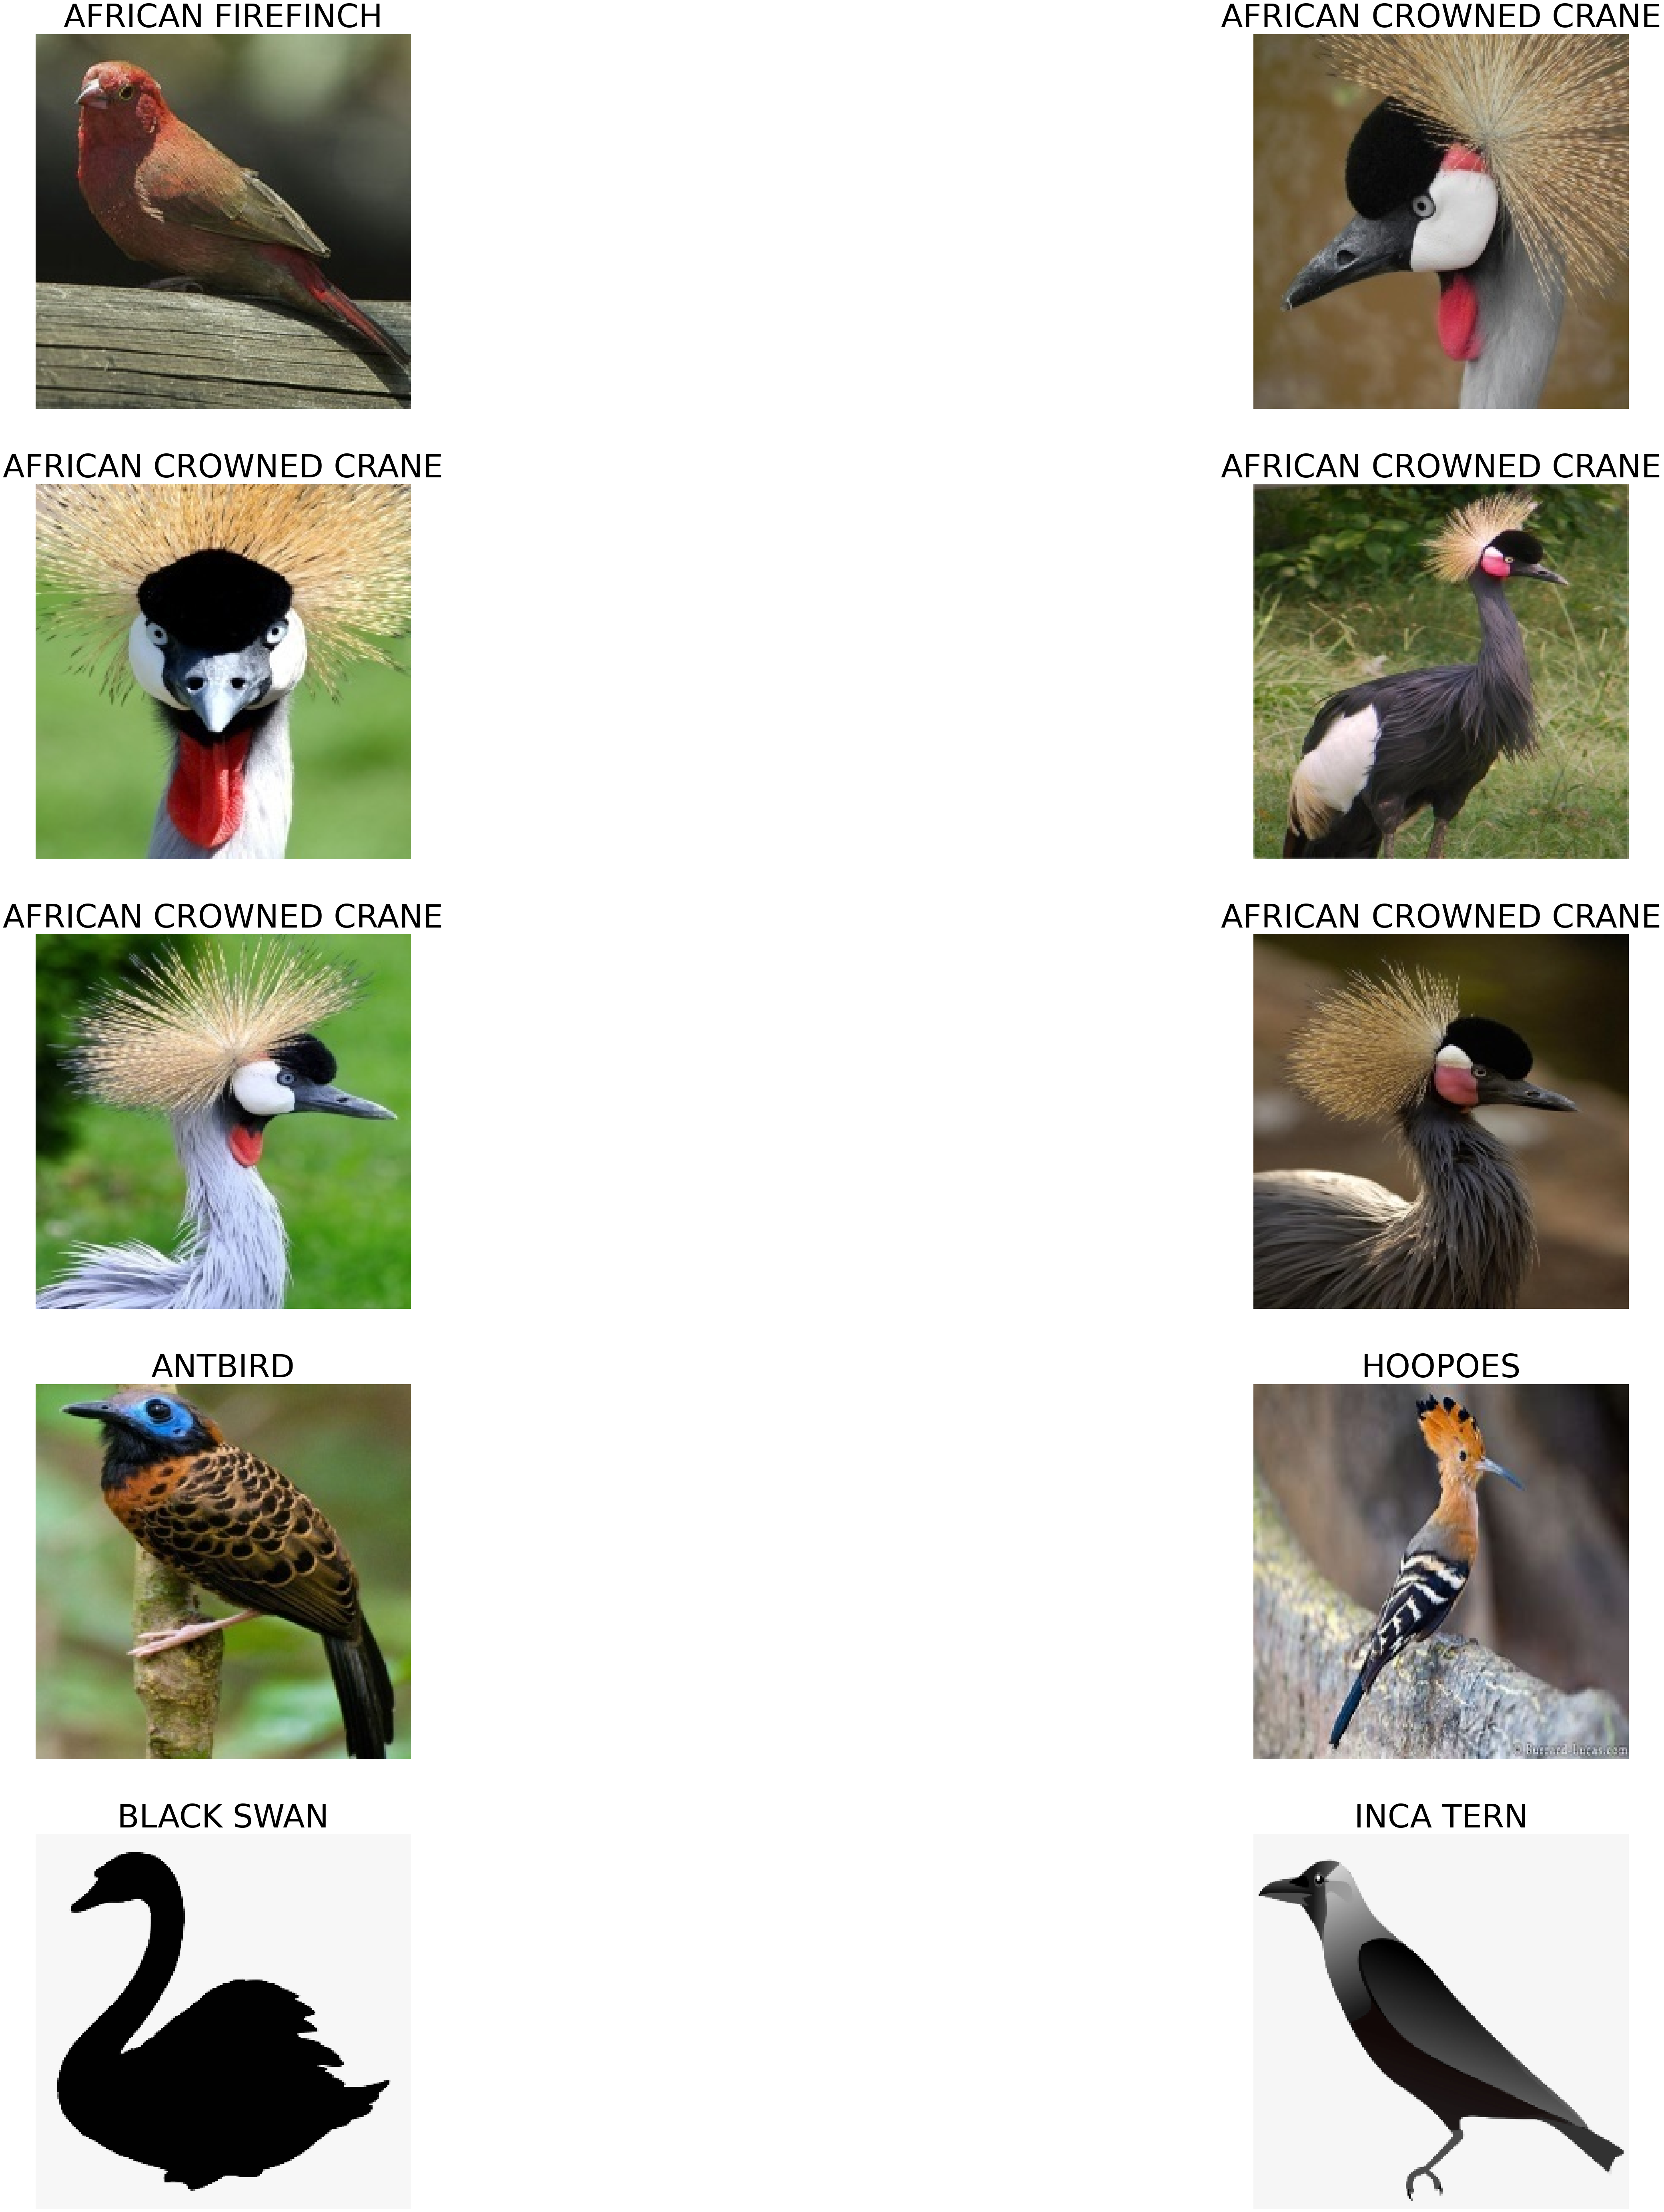

In [65]:
image_grid(predictions, dict)